In [47]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import cross_validation
from sklearn import ensemble
from sklearn.utils import shuffle

import os

%matplotlib inline

In [22]:
TRAIN = pd.read_csv("train.csv")
KAGGLE_TEST = pd.read_csv("test.csv")

In [23]:
TRAIN.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1


In [24]:
KAGGLE_TEST.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [25]:
def peakhour(row):
    if row['workingday'] == 1 and (7 <= row['hour'] <= 9 or 16 <= row['hour'] <= 20):
        return 1
    else:
        return 0

In [73]:
def feature_extraction(df):
    # Copy the DataFrame (TODO)
    dataframe = df.copy(deep=True)
    '''Engineer Features from Data'''
    '''Break Date Time into multiple features: year, month, day, hour etc'''
    dataframe.index = pd.to_datetime(dataframe['datetime']) # creating an index from the timestamp
    dataframe['year']= dataframe.index.year # year
    dataframe['month'] = dataframe.index.month # month
    dataframe['hour'] = dataframe.index.hour # hours
    dataframe['day'] = dataframe.index.dayofweek # day of week (Monday=0, Sunday=6)
    dataframe['dayofyear'] = dataframe.index.dayofyear
    dataframe['week'] = dataframe.index.week
    dataframe['quarter'] = dataframe.index.quarter

    # Weather
    #weather_dummies = pd.get_dummies(dataframe['weather'], prefix='weather')
    #dataframe = pd.concat([dataframe, weather_dummies], axis=1)

    dataframe['weather1'] = dataframe['weather'].map(lambda x: 1 if x == 1 else 0)
    dataframe['weather2'] = dataframe['weather'].map(lambda x: 1 if x == 2 else 0)
    dataframe['weather3'] = dataframe['weather'].map(lambda x: 1 if x == 3 else 0)
    dataframe['weather4'] = dataframe['weather'].map(lambda x: 1 if x == 4 else 0)

    # Season
    #season_dummies = pd.get_dummies(dataframe['season'], prefix='season')
    #dataframe = pd.concat([dataframe, season_dummies], axis=1)

    dataframe['season1'] = dataframe['season'].map(lambda x: 1 if x == 1 else 0)
    dataframe['season2'] = dataframe['season'].map(lambda x: 1 if x == 2 else 0)
    dataframe['season3'] = dataframe['season'].map(lambda x: 1 if x == 3 else 0)
    dataframe['season4'] = dataframe['season'].map(lambda x: 1 if x == 4 else 0)

    # Sunday (Registered: Least # of Bikes Rented on Sundays)
    dataframe['sunday'] = dataframe['day'].map(lambda x: 1 if x == 6 else 0)
     # Sunday (Registered: Highest # of Bikes Rented on Sundays)
    dataframe['saturday'] = dataframe['day'].map(lambda x: 1 if x == 5 else 0)
    # Weekend
    dataframe['weekend'] = dataframe['day'].map(lambda x: 1 if x == 5 or x == 6 else 0)

    # Bucket Hours of Day
    #labels = ['0-3', '4-7', '8-11', '12-15', '16-19', '20-23']
    #lens['age_group'] = pd.cut(dataframe.hour, range(0, 23, 6), right=False, labels=labels)
    dataframe['hour_0_3'] = dataframe['hour'].map(lambda x: 1 if 0 <= x <= 3 else 0)
    dataframe['hour_4_7'] = dataframe['hour'].map(lambda x: 1 if 4 <= x <= 7 else 0)
    dataframe['hour_8_11'] = dataframe['hour'].map(lambda x: 1 if 8 <= x <= 11 else 0)
    dataframe['hour_12_15'] = dataframe['hour'].map(lambda x: 1 if 12 <= x <= 15 else 0)
    dataframe['hour_16_19'] = dataframe['hour'].map(lambda x: 1 if 16 <= x <= 19 else 0)
    dataframe['hour_20_23'] = dataframe['hour'].map(lambda x: 1 if 20 <= x <= 23 else 0)

    # Peak Hours (Morning & Eve) - Registered
    dataframe['peakhours'] = dataframe.apply(peakhour, axis=1)
    # Peak Hours - Rush Hour for Casual
    dataframe['peakhours_cas'] = dataframe['hour'].map(lambda x: 1 if 12 <= x <= 18 else 0)
    
    # Year
    dataframe['year_2011'] = dataframe['year'].map(lambda x: 1 if x == 2011 else 0)
    dataframe['year_2012'] = dataframe['year'].map(lambda x: 1 if x == 2012 else 0)

    return dataframe

In [78]:
def feature_selection(training, kaggle_test=KAGGLE_TEST):
    '''Select Features from Data'''
    '''
    features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',
                'year', 'month', 'hour', 'day', 'dayofyear', 'week', 'quarter',
                'weather1', 'weather2', 'weather3', 'weather4',
                'season1', 'season2', 'season3', 'season4', 'sunday',
                'hour_0_3', 'hour_4_7', 'hour_8_11', 'hour_12_15', 'hour_16_19', 'hour_20_23']


    features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',
                'year', 'month', 'day', 'dayofyear', 'week',
                'weather1', 'weather2', 'weather3', 'weather4',
                'season1', 'season2', 'season3', 'season4', 'sunday',
                'hour_0_3', 'hour_4_7', 'hour_8_11', 'hour_12_15', 'hour_16_19', 'hour_20_23']
    '''
    # Separate Features for Count, Registered & Casual
    features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',
                'month', 'hour', 'day', 'dayofyear', 'week', 'quarter',
                'year_2011', 'year_2012', 'hour_16_19']

    features_r = ['season', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
                  'weather1', 'weather2', 'weather3', 'weather4',
                'month', 'hour', 'day', 'dayofyear',
                'year', 'sunday', 'peakhours']

    features_c = ['season', 'holiday', 'temp', 'atemp', 'humidity', 'windspeed',
                  'weather1', 'weather2', 'weather3', 'weather4',
                'month', 'hour', 'peakhours_cas', 'day', 'dayofyear',
                'year', 'weekend']

    return (features, features_r, features_c)

In [92]:
##RMSLE Score Function (for Kaggle Evaluation)
def RMSLE_score(Y_pred, Y_act):
    a = (np.log(Y_pred+1)-np.log(Y_act+1))
    b = 1./len(Y_pred)
    score = (b*sum(a**(2)))**(0.5)
    return score


def RMSE_score(log_Y_pred, log_Y_act):
    n = len(log_Y_pred)
    return np.sqrt(1/n*(np.sum((log_Y_pred-log_Y_act)**2)))

def inv_log(a):
    return np.exp(a)-1

In [29]:
# Kaggle Baseline
def generate_kaggle_submission(pred, f_name):
    print "\n\n Generating Kaggle Submission File: %s" % (f_name)
    print "Shape of Kaggle Test Set: ", KAGGLE_TEST.shape
    print "Shape of Kaggle Test Set Prediction: ", pred.shape
    print pred
    pred = np.rint(pred)
    pred = np.where(pred < 0, 0, pred)
    df_pred = pd.DataFrame(pred, columns=['count'])

    df_dt = pd.DataFrame(KAGGLE_TEST['datetime'])
    df_dt.reset_index(drop=True, inplace=True)

    print df_dt.head()
    print df_pred.head()

    output = pd.concat([df_dt, df_pred], axis=1)
    print "Shape of Submission Dataframe: ", output.shape
    print output.head()

    file = [os.getcwd(),'/submissions/',f_name]
    output.to_csv("".join(file), index=False)

In [88]:
TRAIN_FX = feature_extraction(TRAIN)
KAGGLE_TEST_FX = feature_extraction(KAGGLE_TEST)

(features, features_r, features_c) = feature_selection(TRAIN_FX, KAGGLE_TEST_FX)

Y_COUNT = np.log(TRAIN_FX['count'] + 1)

TRAIN_FX_FS_R = TRAIN_FX[features_r]
KAGGLE_TEST_FX_FS_R = KAGGLE_TEST_FX[features_r]
Y_R = np.log(TRAIN_FX['registered'] + 1)
X_R = TRAIN_FX_FS_R.values
X1_R = KAGGLE_TEST_FX_FS_R.values

TRAIN_FX_FS_C = TRAIN_FX[features_c]
KAGGLE_TEST_FX_FS_C = KAGGLE_TEST_FX[features_c]
Y_C = np.log(TRAIN_FX['casual'] + 1)
X_C = TRAIN_FX_FS_C.values
X1_C = KAGGLE_TEST_FX_FS_C.values


 [Iteration:1] Num of Training: 8164,  Num of Test: 2722
Residual sum of squares (Count, Registered, Casual): 63973.93, 43460.74, 3056.85
[DEV] R^2 - Variance score (Count, Registered, Casual): 0.93, 0.95, 0.90
RMSLE score (Count, Registered, Casual): 0.30, 0.31, 0.48

 [Iteration:2] Num of Training: 8164,  Num of Test: 2722
Residual sum of squares (Count, Registered, Casual): 61031.02, 41091.50, 2992.12
[DEV] R^2 - Variance score (Count, Registered, Casual): 0.93, 0.95, 0.90
RMSLE score (Count, Registered, Casual): 0.29, 0.30, 0.47

 [Iteration:3] Num of Training: 8164,  Num of Test: 2722
Residual sum of squares (Count, Registered, Casual): 63266.52, 43874.37, 2774.19
[DEV] R^2 - Variance score (Count, Registered, Casual): 0.92, 0.95, 0.89
RMSLE score (Count, Registered, Casual): 0.29, 0.29, 0.48

 [Iteration:4] Num of Training: 8164,  Num of Test: 2722
Residual sum of squares (Count, Registered, Casual): 63376.84, 43601.25, 2936.89
[DEV] R^2 - Variance score (Count, Registered, Casu

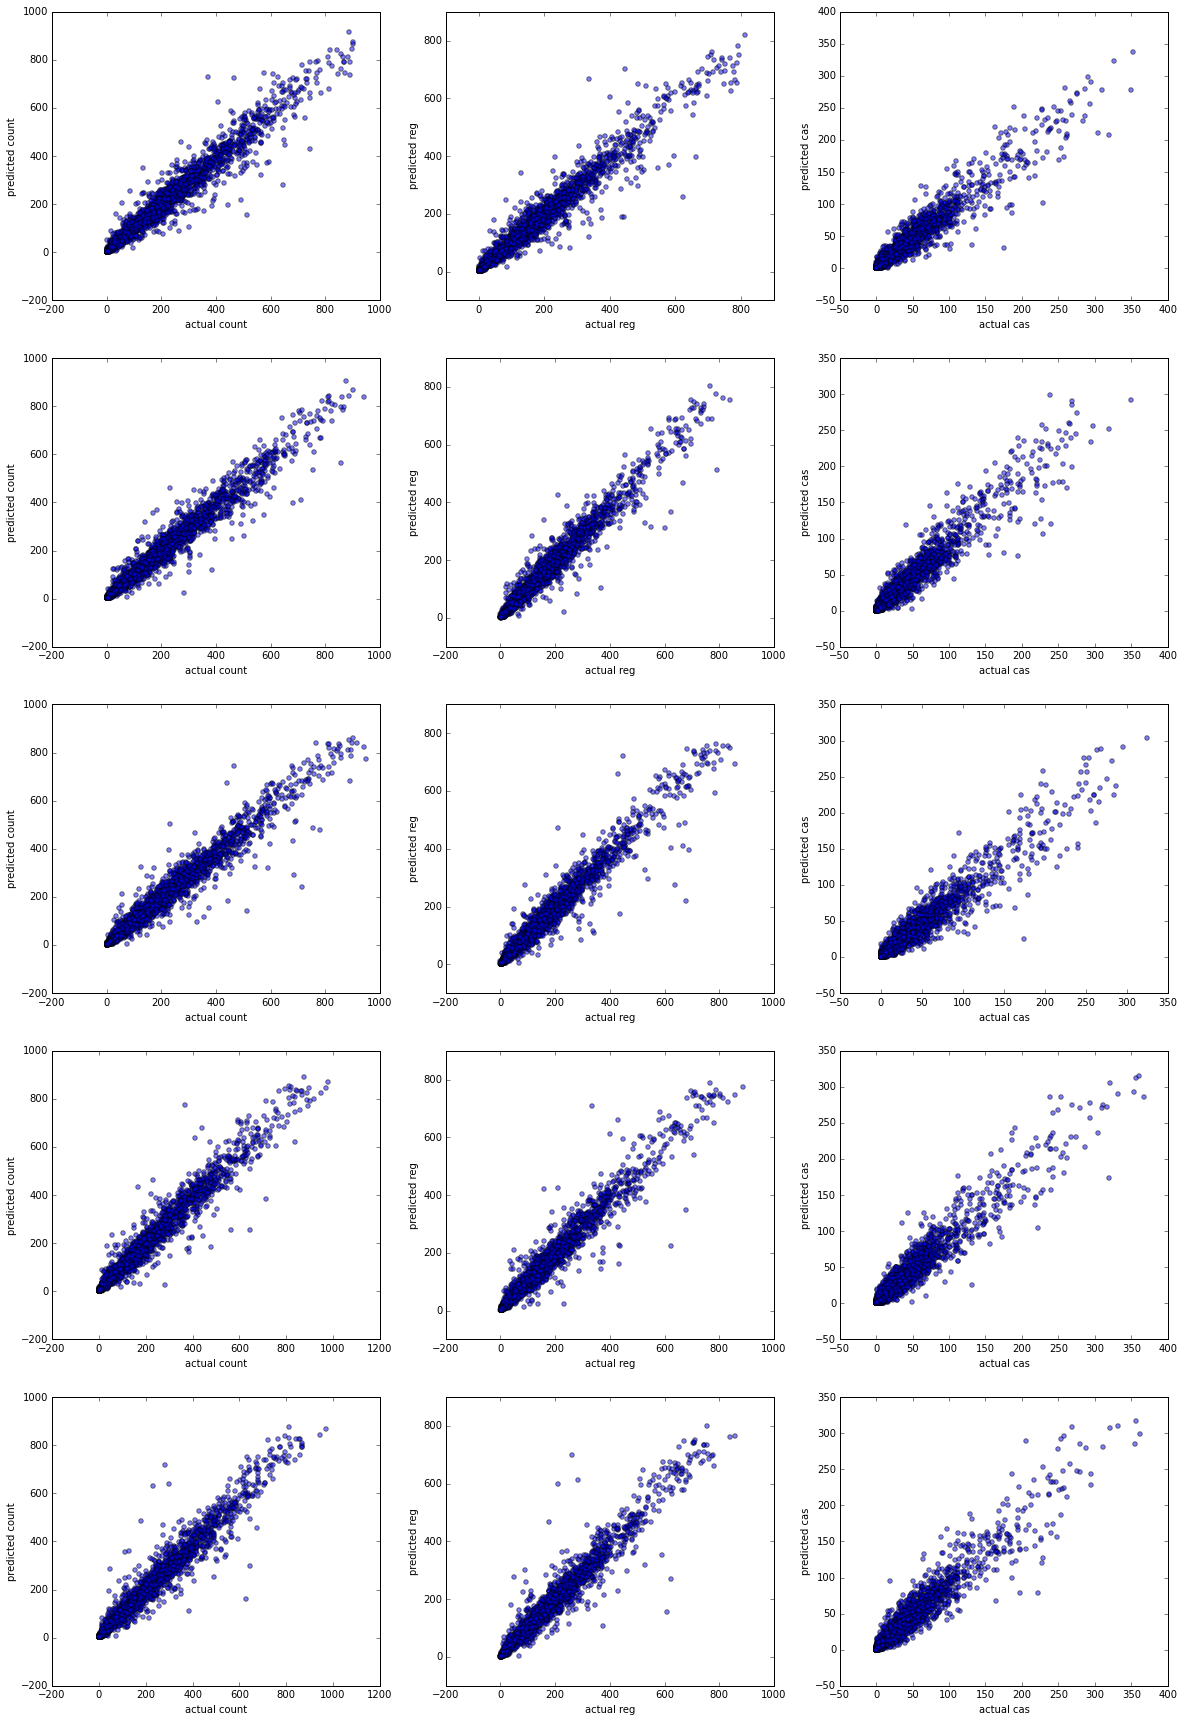

In [93]:
#  Random Forrest with Cross Validation
n_iter = 5
rows = n_iter
cols = 3
cnt = 1
fig = plt.figure(figsize=(20, 30), dpi=80)
ax1 = fig.add_subplot(rows, cols, cnt)


rf_reg = ensemble.RandomForestRegressor(n_estimators=100)
rf_cas = ensemble.RandomForestRegressor(n_estimators=100)
ss = cross_validation.ShuffleSplit(X_R.shape[0], n_iter=n_iter, test_size=0.25, random_state=0)
count = 1
for train_index, test_index in ss:
    print("\n [Iteration:%d] Num of Training: %s,  Num of Test: %s" % (count, len(train_index), len(test_index)))

    # Train the model using the training sets
    rf_reg.fit(X_R[train_index], Y_R[train_index])

     # Train the model using the training sets
    rf_cas.fit(X_C[train_index], Y_C[train_index])


    pred_reg = inv_log(rf_reg.predict(X_R[test_index]))
    pred_cas = inv_log(rf_cas.predict(X_C[test_index]))

    predictions = pred_reg + pred_cas
    
    ax1 = fig.add_subplot(rows, cols, cnt)
    ax1.set_xlabel("actual count")
    ax1.set_ylabel("predicted count")
    ax1.scatter(inv_log(Y_COUNT[test_index]), predictions, alpha=0.5)
    cnt += 1 
    
    ax2 = fig.add_subplot(rows, cols, cnt)
    ax2.set_xlabel("actual reg")
    ax2.set_ylabel("predicted reg")
    ax2.scatter(inv_log(Y_R[test_index]), pred_reg, alpha=0.5)
    cnt += 1 
    
    ax3 = fig.add_subplot(rows, cols, cnt)
    ax3.set_xlabel("actual cas")
    ax3.set_ylabel("predicted cas")
    ax3.scatter(inv_log(Y_C[test_index]), pred_cas, alpha=0.5)
    cnt += 1 

    # The mean square error
    ss_r = np.mean((np.rint(pred_reg) - Y_R[test_index]) ** 2)
    ss_c = np.mean((np.rint(pred_cas) - Y_C[test_index]) ** 2)
    ss = np.mean((np.rint(predictions) - Y_COUNT[test_index]) ** 2)
    print("Residual sum of squares (Count, Registered, Casual): %.2f, %.2f, %.2f"
          % (ss, ss_r, ss_c))
    # Explained variance score: 1 is perfect prediction
    r_squared_r = rf_reg.score(X_R[test_index], Y_R[test_index])
    r_squared_c = rf_cas.score(X_C[test_index], Y_C[test_index])
    r_squared = ( r_squared_r +  r_squared_c) / 2
    print('[DEV] R^2 - Variance score (Count, Registered, Casual): %.2f, %.2f, %.2f' % (r_squared, r_squared_r, r_squared_c))
    # RMSLE Kaggle
    # root mean square log error
    predictions[predictions < 0] = 0
    pred_reg[pred_reg < 0] = 0
    pred_cas[pred_cas < 0] = 0
    rmsle_r = RMSLE_score(pred_reg, inv_log(Y_R[test_index]))
    rmsle_c = RMSLE_score(pred_cas, inv_log(Y_C[test_index]))
    rmsle = RMSLE_score(predictions, inv_log(Y_COUNT[test_index]))
    print "RMSLE score (Count, Registered, Casual): %.2f, %.2f, %.2f" % (rmsle, rmsle_r, rmsle_c)

    count += 1





[Registered] Feature ranking:
1. Feature 11 - hour : (0.715937)
2. Feature 16 - peakhours : (0.063126)
3. Feature 13 - dayofyear : (0.056117)
4. Feature 14 - year : (0.039995)
5. Feature 1 - workingday : (0.034547)
6. Feature 12 - day : (0.029067)
7. Feature 4 - humidity : (0.015930)
8. Feature 2 - temp : (0.013350)
9. Feature 3 - atemp : (0.009420)
10. Feature 8 - weather3 : (0.008433)
11. Feature 5 - windspeed : (0.006903)
12. Feature 10 - month : (0.003681)
13. Feature 15 - sunday : (0.001187)
14. Feature 6 - weather1 : (0.000942)
15. Feature 0 - season : (0.000720)
16. Feature 7 - weather2 : (0.000644)
17. Feature 9 - weather4 : (0.000002)


[Casual] Feature ranking:
1. Feature 11 - hour : (0.541820)
2. Feature 2 - temp : (0.196503)
3. Feature 3 - atemp : (0.049426)
4. Feature 13 - day : (0.043506)
5. Feature 14 - dayofyear : (0.040844)
6. Feature 4 - humidity : (0.036751)
7. Feature 16 - weekend : (0.021411)
8. Feature 5 - windspeed : (0.016719)
9. Feature 12 - peakhours_cas : (

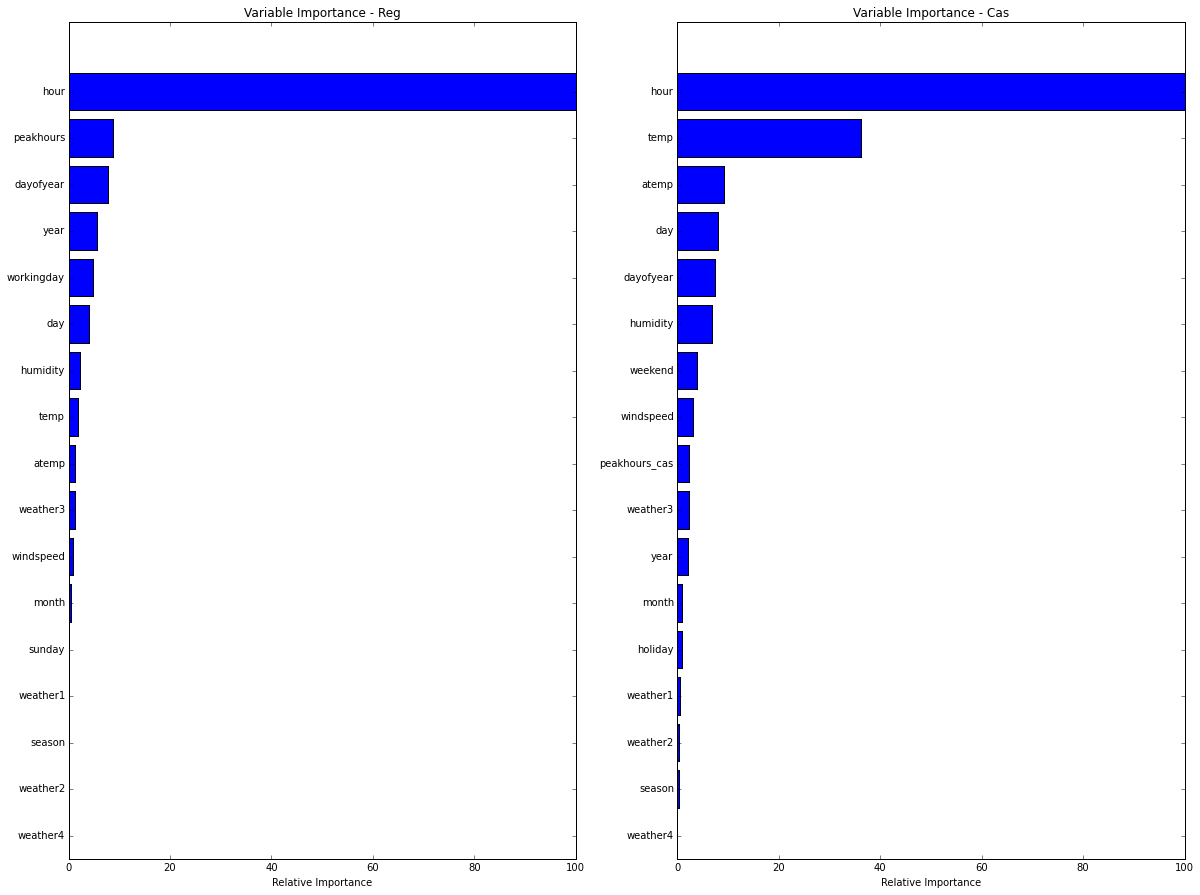

In [94]:
# Train the model using the entire data set
rf_reg.fit(X_R, Y_R)
rf_cas.fit(X_C, Y_C)

feature_importances__reg = rf_reg.feature_importances_
#print feature_importances__reg
indices = np.argsort(feature_importances__reg)[::-1]

# Print the feature ranking
print("\n\n[Registered] Feature ranking:")
for f in xrange(len(features_r)):
    print("%d. Feature %d - %s : (%f)" % (f + 1, indices[f],  features_r[indices[f]], feature_importances__reg[indices[f]]))
    
    
feature_importances__cas = rf_cas.feature_importances_
#print feature_importances__cas
indices = np.argsort(feature_importances__cas)[::-1]

# Print the feature ranking
print("\n\n[Casual] Feature ranking:")
for f in xrange(len(features_c)):
    print("%d. Feature %d - %s : (%f)" % (f + 1, indices[f],  features_c[indices[f]], feature_importances__cas[indices[f]]))
    
# Plot feature importance
fig = plt.figure(figsize=(20, 15), dpi=80)
# make importances relative to max importance
feature_importances__reg = 100.0 * (feature_importances__reg / feature_importances__reg.max())
sorted_idx = np.argsort(feature_importances__reg)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importances__reg[sorted_idx], align='center')
plt.yticks(pos, np.array(features_r)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance - Reg')

# make importances relative to max importance
feature_importances__cas = 100.0 * (feature_importances__cas / feature_importances__cas.max())
sorted_idx = np.argsort(feature_importances__cas)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importances__cas[sorted_idx], align='center')
plt.yticks(pos, np.array(features_c)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance - Cas')
plt.show()


In [95]:
predictions = inv_log(rf_reg.predict(X1_R)) + inv_log(rf_cas.predict(X1_C))
generate_kaggle_submission(predictions, "rf.csv")



 Generating Kaggle Submission File: rf.csv
Shape of Kaggle Test Set:  (6493, 9)
Shape of Kaggle Test Set Prediction:  (6493,)
[  11.36467875    5.53606302    3.04287363 ...,  166.2282454   113.97143555
   70.72382609]
              datetime
0  2011-01-20 00:00:00
1  2011-01-20 01:00:00
2  2011-01-20 02:00:00
3  2011-01-20 03:00:00
4  2011-01-20 04:00:00
   count
0     11
1      6
2      3
3      2
4      2
Shape of Submission Dataframe:  (6493, 2)
              datetime  count
0  2011-01-20 00:00:00     11
1  2011-01-20 01:00:00      6
2  2011-01-20 02:00:00      3
3  2011-01-20 03:00:00      2
4  2011-01-20 04:00:00      2


In [83]:
offset = int(X_R.shape[0] * 0.9)

X_R_S, Y_R_S = shuffle(X_R, Y_R, random_state=13)
X_R_S_TRAIN, Y_R_S_TRAIN = X_R_S[:offset], Y_R_S[:offset]
X_R_S_TEST, Y_R_S_TEST = X_R_S[offset:], Y_R_S[offset:]

X_C_S, Y_C_S = shuffle(X_C, Y_C, random_state=13)
X_C_S_TRAIN, Y_C_S_TRAIN = X_C_S[:offset], Y_C_S[:offset]
X_C_S_TEST, Y_C_S_TEST = X_C_S[offset:], Y_C_S[offset:]

Y_COUNT_TEST = Y_COUNT[offset:]

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.01, 'loss': 'ls'}
gbr_reg = ensemble.GradientBoostingRegressor(**params)
gbr_cas = ensemble.GradientBoostingRegressor(**params)

gbr_reg.fit(X_R_S_TRAIN, Y_R_S_TRAIN)
gbr_cas.fit(X_C_S_TRAIN, Y_C_S_TRAIN)

pred_reg = gbr_reg.predict(X_R_S_TEST)
pred_cas = gbr_cas.predict(X_C_S_TEST)

predictions = pred_reg + pred_cas

# The mean square error
sum_squares = np.mean((np.rint(predictions) - Y_COUNT_TEST) ** 2)
print("Residual sum of squares: %.2f"
      % sum_squares)
# Explained variance score: 1 is perfect prediction
r_squared = (gbr_reg.score(X_R_S_TEST, Y_R_S_TEST) + gbr_cas.score(X_C_S_TEST, Y_C_S_TEST)) / 2
print('[DEV] R^2 - Variance score: %.2f' % r_squared)
# RMSLE Kaggle
# root mean square log error
predictions[predictions < 0] = 0
rmsle = RMSLE_score(predictions, Y_COUNT_TEST)
print "RMSLE score: %.6f" % rmsle

Residual sum of squares: 62386.80
[DEV] R^2 - Variance score: 0.88
RMSLE score: 1.800006
